In [1]:
import torchvision.transforms as transforms

transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ]
)

In [2]:
import torch
import torchvision
train = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform_train)
test = torchvision.datasets.CIFAR10(root='./data',train=False,download=False,transform=transform_test)

100%|██████████| 170M/170M [00:02<00:00, 60.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
trainloader = torch.utils.data.DataLoader(train,batch_size=128,shuffle=True)
testloader = torch.utils.data.DataLoader(test,batch_size=128,shuffle=False)

In [4]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  
        return torch.relu(out)


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = ResidualBlock(64, 128, stride=2)
        self.layer2 = ResidualBlock(128, 256, stride=2)
        self.layer3 = ResidualBlock(256, 512, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [5]:
model = CNN()

In [6]:
with torch.no_grad():
  a = next(iter(trainloader))
  print(a[0].shape)
  a = model(a[0])
  print(a.shape)

torch.Size([128, 3, 32, 32])
torch.Size([128, 10])


In [7]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

device = "cuda"
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
model = model.to(device)
from tqdm import tqdm
from tqdm import tqdm

from tqdm import tqdm
lr = 0.001
for i in range(50):
    correct, total, running_loss = 0, 0, 0
    train_bar = tqdm(trainloader, desc=f'Train Epoch {i}')

    for image, label in train_bar:
        image, label = image.to(device), label.to(device)

        out = model(image)
        loss_value = loss(out, label)

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        predictions = out.argmax(dim=1)
        correct += (predictions == label).sum().item()
        total += label.size(0)
        running_loss += loss_value.item()

        train_bar.set_postfix(loss=running_loss / total, acc=100 * correct / total)
        writer.add_scalar('Loss/train', running_loss / total, i)    
        writer.add_scalar('Accuracy/train', 100 * correct / total, i)
    correct, total, test_loss = 0, 0, 0
    test_bar = tqdm(testloader, desc=f'Test Epoch {i}')

    with torch.no_grad():
        for test, test_label in test_bar:
            test, test_label = test.to(device), test_label.to(device)

            test_out = model(test)
            loss_value = loss(test_out, test_label)
            test_loss += loss_value.item()

            predictions = test_out.argmax(dim=1)
            correct += (predictions == test_label).sum().item()
            total += test_label.size(0)

            test_bar.set_postfix(loss=test_loss / total, acc=100 * correct / total)
            writer.add_scalar('Loss/test', test_loss / total, i)
            writer.add_scalar('Accuracy/test', 100 * correct / total, i)
    scheduler.step(test_loss)
    if optimizer.param_groups[0]["lr"] != lr:
        lr = optimizer.param_groups[0]["lr"]
        print(f"Updated learning rate: {lr}")

Test Epoch 42: 100%|██████████| 79/79 [00:03<00:00, 25.12it/s, acc=86.1, loss=0.0036]


Updated learning rate: 0.0001


Test Epoch 49: 100%|██████████| 79/79 [00:03<00:00, 25.81it/s, acc=89.2, loss=0.00305]


In [8]:
torch.save(model.state_dict(), 'cifar10_cnn.pth')

In [9]:
filters = model.conv1.weight[:5]
filters = filters.detach().cpu()
filters = filters - filters.min()
filters = filters / filters.max()
filters = filters.permute(0, 2, 3, 1).numpy()
filters.shape

(5, 3, 3, 3)

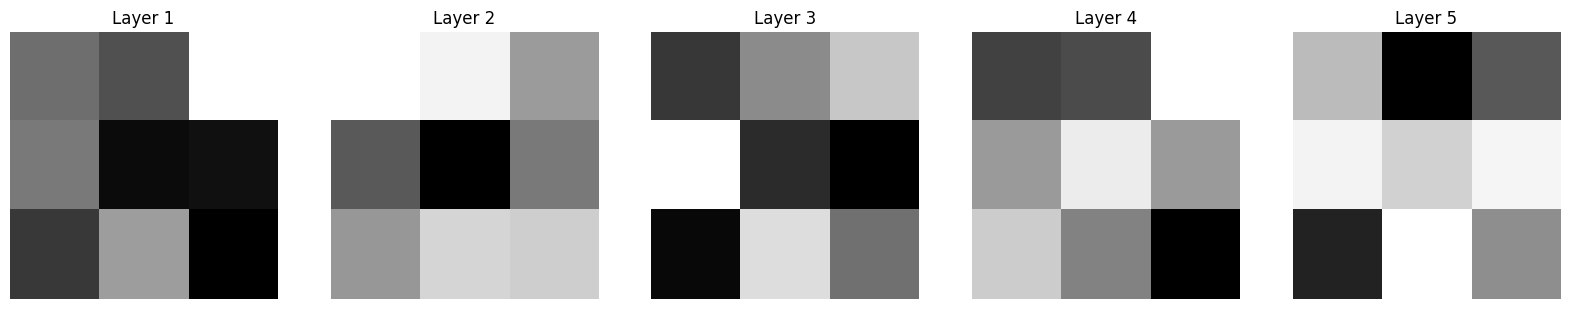

In [10]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, filter in enumerate(filters):
    axs[i].imshow(np.mean(filter, axis=0), cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Layer {i + 1}')